In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random
import matplotlib.pyplot as plt
import numpy as np

def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        

In [2]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [5]:
glass_image_id = os.listdir('images/glass')[0]
glass_image = load_image(os.path.join('images/glass',glass_image_id))
print(f'shape: {glass_image.shape}')
print(f'type: {type(glass_image)}')
model.predict(glass_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[3.42926143e-07, 1.43635009e-06, 8.04404976e-07, 1.20845565e-08,
        3.00839417e-07, 8.62631532e-06, 3.56399323e-06, 2.59979679e-05,
        2.93806588e-05, 2.35313764e-05, 2.45438816e-08, 1.03180874e-07,
        2.13800331e-06, 6.42641780e-08, 2.74169622e-07, 3.19953699e-07,
        4.46853306e-07, 9.64971534e-08, 1.03083707e-07, 8.81214675e-08,
        2.55004693e-07, 4.44471539e-07, 2.31355756e-07, 1.59576048e-05,
        1.19408412e-06, 7.39955851e-07, 5.99733085e-07, 4.41912562e-06,
        1.00419200e-07, 4.97496387e-07, 6.13533302e-07, 7.67594940e-07,
        1.91537174e-06, 3.11388249e-05, 8.66852645e-07, 1.67464952e-06,
        2.64508799e-05, 9.35341916e-07, 5.18386378e-06, 1.66486043e-05,
        6.85054874e-06, 1.84844100e-06, 7.67602955e-07, 5.94075345e-07,
        8.20729474e-06, 2.03952022e-05, 2.84273142e-06, 3.23361928e-06,
        1.08011427e-05, 2.35445750e-05, 2.99670864e-05, 3.04167429e-07,
        8.14421292e-05, 2.24312475e-06, 5.31086880e-05, 4.940909

In [6]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)
glass_image_id = os.listdir('images/glass')[0]
glass_image = load_image(os.path.join('images/glass',glass_image_id))
model.predict(glass_image).shape

(1, 1024)

In [7]:
x = Dropout(rate=0.4)(model.output)
# This determines the number of outputs, and thus the number of categories, in my test case 2: dog or cat
x = Dense(2)(x)
x = Softmax()(x)
model= Model(model.inputs, x)
for layer in model.layers[:-3]:
    layer.trainable = False
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    './images', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 203 images belonging to 4 classes.
Found 21 images belonging to 4 classes.


In [8]:
batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[32,2] labels_size=[32,4]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits
 (defined at E:\software\anaconda\lib\site-packages\keras\backend.py:5020)
]] [Op:__inference_train_function_7015]

Errors may have originated from an input operation.
Input Source operations connected to node categorical_crossentropy/softmax_cross_entropy_with_logits:
In[0] categorical_crossentropy/softmax_cross_entropy_with_logits/Reshape:	
In[1] categorical_crossentropy/softmax_cross_entropy_with_logits/Reshape_1:

Operation defined at: (most recent call last)
>>>   File "E:\software\anaconda\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "E:\software\anaconda\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "E:\software\anaconda\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "E:\software\anaconda\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "E:\software\anaconda\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\tornado\gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\tornado\gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-8-1c02a3d5d458>", line 3, in <module>
>>>     history = model.fit(
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\engine\training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
>>>     return backend.categorical_crossentropy(
>>> 
>>>   File "E:\software\anaconda\lib\site-packages\keras\backend.py", line 5020, in categorical_crossentropy
>>>     return tf.nn.softmax_cross_entropy_with_logits(
>>> 

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
random_concrete = random.choice(os.listdir('images/concrete/'))
concrete_path = os.path.join('images/concrete',random_concrete)
concrete = load_image(cat_path)
random_glass = random.choice(os.listdir('images/glass/'))
glass_path = os.path.join('images/glass',random_glass)
glass = load_image(glass_path)
tf.keras.preprocessing.image.load_img(concrete_path, target_size=(224,224))
tf.keras.preprocessing.image.load_img(glass_path, target_size=(224,224))
print(f'''concrete:{np.round(model.predict(concrete),2)}''')
print(f'''glass:{np.round(model.predict(glass),2)}''')



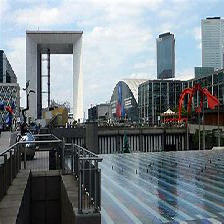

In [11]:
OIP_path = 'OIP.jpg'
OIP = load_image(OIP_path)
tf.keras.preprocessing.image.load_img(OIP_path, target_size=(224,224))

In [12]:
print(f'''OIP:{np.round(model.predict(OIP),2)}''')

OIP:[[0.7 0.3]]
